In [2]:
# --- TEST DATA_LOADER ---

from src import data_loader as dl
import pandas as pd

filepath = r'data/U13271915_20250101_20251029.csv'
output_excel_path = r'data/report_output.xlsx'

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 150)

print(f"Loading report from: {filepath}...")
results = dl.load_ibkr_report(filepath)

if results:
    print("\nReport loaded successfully.")
    
    try:
        # Use pd.ExcelWriter to save both DataFrames to one file
        # on separate sheets.
        with pd.ExcelWriter(output_excel_path) as writer:
            results['initial_state'].to_excel(writer, sheet_name='initial_state', index=False)
            results['events'].to_excel(writer, sheet_name='events', index=False)
            results['financial_info'].to_excel(writer, sheet_name='financial_info', index=False)
            
        print(f"Successfully saved data to: {output_excel_path}")
        
    except ImportError:
        print("\n--- ERROR ---")
        print("To save to Excel, you need the 'openpyxl' library.")
        print("Please install it by running this in your terminal:")
        print("pip install openpyxl")
    except Exception as e:
        print(f"\nAn error occurred while saving to Excel: {e}")

    # --- 4. Print results to console as before ---
    print("\n" + "="*80 + "\n")
    print("--- 1. Initial State DataFrame ---")
    print(results['initial_state'])
    
    print("\n" + "="*80 + "\n")
    print("--- 2. Master Event Log ---")
    print(results['events'])

else:
    print("Data loading failed. No results to save.")

Loading report from: data/U13271915_20250101_20251029.csv...

Report loaded successfully.
Successfully saved data to: data/report_output.xlsx


--- 1. Initial State DataFrame ---
   symbol asset_category currency      quantity  value_native
0    ANFO          Stock      CHF      0.000000      0.000000
1    ASML          Stock      USD      2.000000   1386.160000
2   CHDVD          Stock      CHF     45.000000   7106.400000
3     DGE          Stock      GBP     56.000000   1421.000000
4    EMBC          Stock      CHF      0.000000      0.000000
5    FLIN          Stock      USD    192.000000   7276.800000
6    FONC          Stock      CHF      0.000000      0.000000
7      HO          Stock      EUR      0.000000      0.000000
8    IBKR          Stock      USD      3.036800    536.511456
9    IHYU          Stock      CHF      0.000000      0.000000
10   IUSC          Stock      CHF     86.000000   7833.740000
11    IVV          Stock      USD     12.000000   7064.160000
12    KGX      

In [3]:
import pandas as pd
import os
from src import data_loader as dl
from src import data_processor as dp
from src import market_data_loader as mdl

# --- 1. Setup Paths ---
input_csv_path = r'data/U13271915_20250101_20251029.csv'
output_excel_path = r'data/market_data.xlsx'

# Check if input file exists before proceeding
if not os.path.exists(input_csv_path):
    print(f"Error: Input file not found at {input_csv_path}")
else:
    print(f"Input file found: {input_csv_path}")

    # --- 2. Run the Pipeline ---

    print("\n1. Loading IBKR Report...")
    # Load raw data
    data_package = dl.load_ibkr_report(input_csv_path)

    print("2. Applying Split Adjustments...")
    # Process splits/events
    processed_data = dp.apply_split_adjustments(data_package)
    print(processed_data)

    print("3. Downloading Market Data...")
    # Download from Yahoo Finance
    # This returns 'market_data_map' (Dictionary of DataFrames)
    final_package = mdl.load_market_data(processed_data)

    # --- 3. Inspect and Save Results ---

    if not final_package:
        print("Warning: No market data was downloaded. Check internet connection or ticker logic.")
    else:
        print(f"\nSuccess! Downloaded data for {len(final_package)} assets.")
        
        # A. Quick Inspection of first asset
        first_symbol = list(final_package.keys())[0]
        print(f"--- Sample Data for: {first_symbol} ---")
        print(final_package[first_symbol].head())
        print("-" * 30)

        # B. Export to Excel
        print(f"4. Saving to {output_excel_path}...")
        
        # We use ExcelWriter to save multiple dataframes to one file (one sheet per symbol)
        try:
            with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
                for symbol, df_data in final_package.items():
                    # Excel sheet names are limited to 31 chars and cannot contain [] : * ? / \
                    clean_sheet_name = str(symbol).replace('/', '_')[:31]
                    df_data.to_excel(writer, sheet_name=clean_sheet_name)
            print("Excel file saved successfully.")
            
        except Exception as e:
            print(f"Error saving Excel file: {e}")

Input file found: data/U13271915_20250101_20251029.csv

1. Loading IBKR Report...
2. Applying Split Adjustments...
Processor: Moved 2 historical events to start date 2025-01-01
Processor: Detached symbol from 2 historical tax events (Ghost Assets).
{'initial_state':    symbol asset_category currency      quantity  value_native
0    ANFO          Stock      CHF      0.000000      0.000000
1    ASML          Stock      USD      2.000000   1386.160000
2   CHDVD          Stock      CHF     45.000000   7106.400000
3     DGE          Stock      GBP     56.000000   1421.000000
4    EMBC          Stock      CHF      0.000000      0.000000
5    FLIN          Stock      USD    192.000000   7276.800000
6    FONC          Stock      CHF      0.000000      0.000000
7      HO          Stock      EUR      0.000000      0.000000
8    IBKR          Stock      USD     12.147200    536.511456
9    IHYU          Stock      CHF      0.000000      0.000000
10   IUSC          Stock      CHF     86.000000   7

In [4]:
import pandas as pd
from src import data_loader as dl
from src import data_processor as dp
from src import market_data_loader as mdl
from src import portfolio_reconstructor as pr

filepath = r'data/U13271915_20250101_20251029.csv'
raw_data = dl.load_ibkr_report(filepath)
clean_data = dp.apply_split_adjustments(raw_data)
market_data = mdl.load_market_data(clean_data)

portfolio_data = pr.reconstruct_portfolio(clean_data, market_data)

excel_path = r'data/portfolio.xlsx'

with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for key, data_frame in portfolio_data.items():
        # Safety check: ensure the item is actually a pandas object (DataFrame or Series)
        if hasattr(data_frame, 'to_excel'):
            # Sheet names have a 31 char limit in Excel, so we truncate just in case
            sheet_name = key[:31] 
            data_frame.to_excel(writer, sheet_name=sheet_name)
            print(f" - Wrote sheet: {sheet_name}")

print(portfolio_data)


Processor: Moved 2 historical events to start date 2025-01-01
Processor: Detached symbol from 2 historical tax events (Ghost Assets).
Found 23 initial stock positions.
Cleaning up redundant currency columns in Security Engine: ['CHF', 'EUR', 'GBP', 'USD']
 - Wrote sheet: holdings
 - Wrote sheet: prices
 - Wrote sheet: valuation_native
 - Wrote sheet: valuation_base
 - Wrote sheet: total_nav
{'holdings':             ANFO  ASML  CHDVD   DGE    EMBC  ...   VTI          CHF           EUR           GBP          USD
2025-01-01   0.0   2.0   45.0  56.0     0.0  ...   0.0 -14909.51088  2.342153e+01  1.557000e+01    62.130000
2025-01-02   0.0   2.0   45.0  56.0     0.0  ...   0.0 -14909.51088  2.342153e+01  1.557000e+01    62.130000
2025-01-03   0.0   2.0   45.0  56.0     0.0  ...   0.0 -14909.51088  2.342153e+01  1.557000e+01    62.130000
2025-01-04   0.0   2.0   45.0  56.0     0.0  ...   0.0 -14909.51088  2.342153e+01  1.557000e+01    62.130000
2025-01-05   0.0   2.0   45.0  56.0     0.0  ...

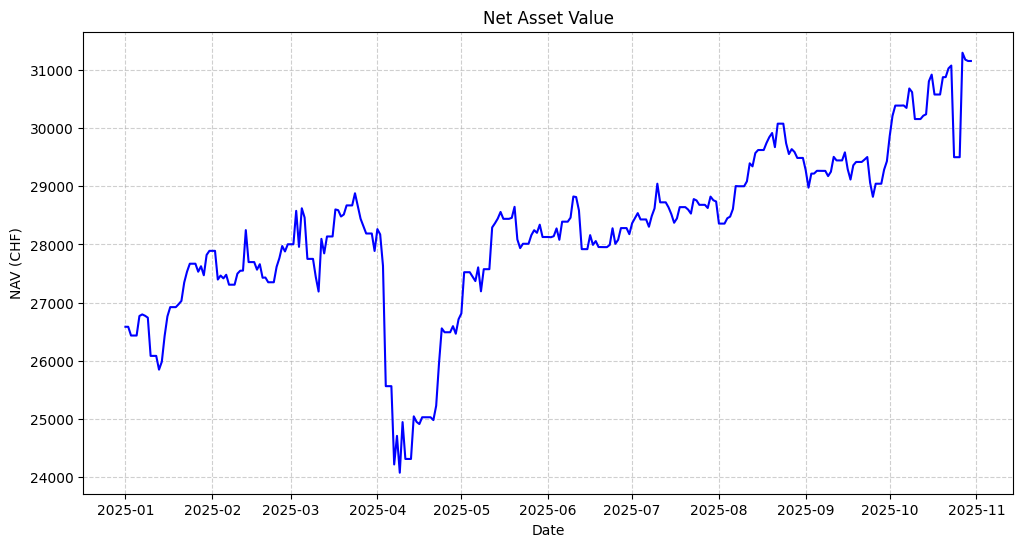

In [5]:
import matplotlib.pyplot as plt

# 1. Setup the canvas (width, height in inches)
plt.figure(figsize=(12, 6))
    
# 2. Plot the data
# x-axis is the Index (Date), y-axis is the 'Close' price
plt.plot(portfolio_data['total_nav'], color='blue')
    
# 3. Styling
plt.title(f"Net Asset Value")
plt.xlabel("Date")
plt.ylabel("NAV (CHF)") # Should be GBP if your logic worked!
plt.grid(True, linestyle='--', alpha=0.6) # Adds a grid for readability
    
# 4. Display
plt.show()


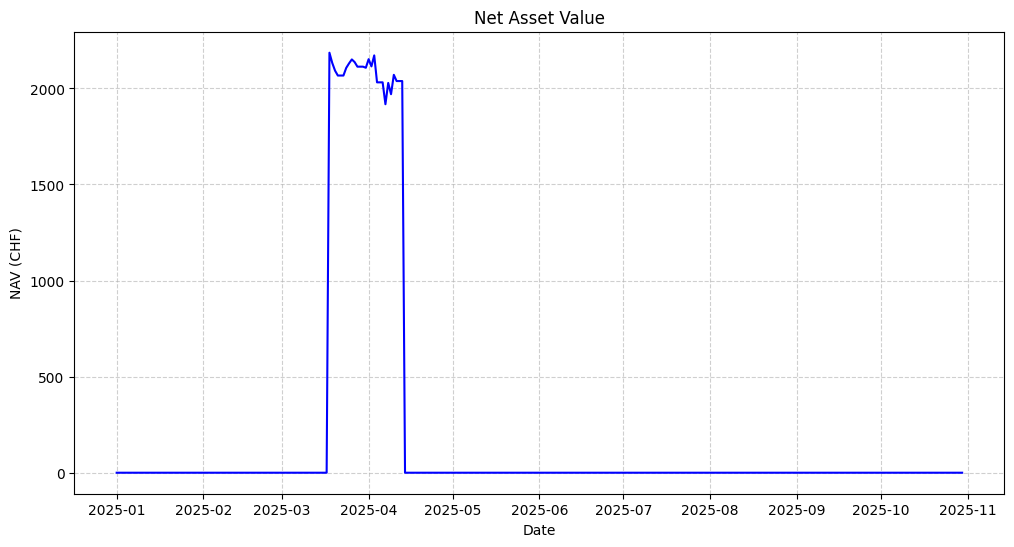

In [6]:
import matplotlib.pyplot as plt

# 1. Setup the canvas (width, height in inches)
plt.figure(figsize=(12, 6))
    
# 2. Plot the data
# x-axis is the Index (Date), y-axis is the 'Close' price
plt.plot(portfolio_data['valuation_base']['HO'], color='blue')
    
# 3. Styling
plt.title(f"Net Asset Value")
plt.xlabel("Date")
plt.ylabel("NAV (CHF)") # Should be GBP if your logic worked!
plt.grid(True, linestyle='--', alpha=0.6) # Adds a grid for readability
    
# 4. Display
plt.show()

In [7]:
import yfinance as yf
import pandas as pd

ticker = "NVDA"

df = yf.download(
    ticker, 
    period="1y", 
    auto_adjust=False, 
    progress=False
)
print(df)


Price        Adj Close       Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                             
2024-11-19  146.967850  147.009995  147.130005  140.990005  141.320007  227834900
2024-11-20  145.848175  145.889999  147.559998  142.729996  147.410004  309871700
2024-11-21  146.627960  146.669998  152.889999  140.699997  149.350006  400946600
2024-11-22  141.909286  141.949997  147.160004  141.100006  145.929993  236406200
2024-11-25  135.981003  136.020004  142.050003  135.820007  141.990005  344941900
...                ...         ...         ...         ...         ...        ...
2025-11-13  186.860001  186.860001  191.440002  183.850006  191.050003  207423100
2025-11-14  190.169998  190.169998  191.009995  180.580002  182.860001  186591900
2025-11-17  186.600006  186.600006  189.000000  184.320007  185.970001  173628900
2025-11-18  181.

In [8]:
import pandas as pd
from src import data_loader as dl
from src import market_data_loader as mdl
from src import ibkr_rates_scraper as irs
from src import simulation_engine as sim

filepath = r'data/U13271915_20250101_20251029.csv' 
data_package = dl.load_ibkr_report(filepath)
start, end = data_package['report_start_date'], data_package['report_end_date']

print("--- 1. SCRAPER TEST ---")
daily_rates = irs.get_daily_margin_rates(start, end)
print(f"Scraped Rates: {len(daily_rates)} rows")

print("\n--- 2. SIMULATION TEST ---")
market_data = mdl.load_market_data(data_package)
engine = sim.MonteCarloEngine(data_package, market_data, daily_rates)
results = engine.generate_scenario(num_paths=1)

sim_events = results[0]['events']
divs = sim_events[sim_events['event_type'] == 'DIVIDEND']

print(f"Trades: {len(sim_events[sim_events['event_type'] == 'TRADE_BUY'])}")
print(f"Margins: {len(sim_events[sim_events['event_type'] == 'INTEREST_MARGIN'])}")
print(f"Dividends: {len(divs)}")

if not divs.empty:
    print("Dividend Injection Successful! (Projected from previous year)")
    print(divs.head(3)[['timestamp', 'symbol', 'cash_change_native']])
else:
    print("No Dividends. (Check if stocks actually paid dividends in 2024 for projection)")

--- 1. SCRAPER TEST ---
Scraping IBKR rates for 11 months...
Scraped Rates: 152 rows

--- 2. SIMULATION TEST ---
Generating 1 Inventory-Aware paths...
Trades: 17
Margins: 410
Dividends: 40
Dividend Injection Successful! (Projected from previous year)
     timestamp symbol  cash_change_native
73  2025-02-11   ASML            3.140000
78  2025-02-13   EMBC           33.529363
102 2025-02-20   MSFT            7.221765


In [9]:
import pandas as pd
from src import data_loader as dl
from src import market_data_loader as mdl
from src import simulation_engine as sim

# --- 1. LOAD DATA ---
filepath = r'data/U13271915_20250101_20251029.csv' 
data_package = dl.load_ibkr_report(filepath)

# --- 2. LOAD MARKET DATA ---
print("Downloading Market Data...")
market_data = mdl.load_market_data(data_package)

# --- 3. INSPECT RAW YAHOO DATA ---
print("\n--- DIAGNOSTIC: RAW YAHOO DATA ---")
sample_stock = None
# Find a stock that definitely pays dividends (e.g., starts with 'N', 'M', 'A')
for sym, df in market_data.items():
    if 'Dividends' in df.columns and df['Dividends'].sum() > 0:
        sample_stock = sym
        break

if sample_stock:
    print(f"Found Dividend Payer: {sample_stock}")
    divs = market_data[sample_stock]['Dividends']
    divs = divs[divs > 0]
    print(f"Raw Dividend Dates (Index Type: {type(divs.index)}):")
    print(divs.head(3))
    print(f"First Div Date TZ Info: {divs.index[0].tzinfo}")
else:
    print("CRITICAL: No dividends found in ANY downloaded stock data.")

# --- 4. INSPECT ENGINE INTERNALS ---
print("\n--- DIAGNOSTIC: ENGINE INTERNALS ---")
# Use an empty rate df just to init the engine
dummy_rates = pd.DataFrame() 
engine = sim.MonteCarloEngine(data_package, market_data, dummy_rates)

if sample_stock and sample_stock in engine.dividend_map:
    eng_divs = engine.dividend_map[sample_stock]
    print(f"Engine Stored Dividends for {sample_stock}:")
    print(eng_divs.head(3))
    if not eng_divs.empty:
        print(f"Engine Div Date TZ Info: {eng_divs.index[0].tzinfo}")

# --- 5. SIMULATION LOOP CHECK ---
print("\n--- DIAGNOSTIC: SIMULATION MATCHING ---")
# We manually simulate the matching logic
report_start = data_package['report_start_date'].replace(tzinfo=None)
print(f"Simulation Start Date (Naive): {report_start}")

if sample_stock and not eng_divs.empty:
    # Check if any dividend falls in the report period
    mask = (eng_divs.index >= report_start)
    future_divs = eng_divs[mask]
    
    if not future_divs.empty:
        target_date = future_divs.index[0]
        print(f"Target Dividend Date: {target_date}")
        
        # Simulate the loop date
        sim_date = pd.Timestamp(target_date.year, target_date.month, target_date.day)
        print(f"Loop Date Generated: {sim_date}")
        
        match = sim_date in eng_divs.index
        print(f"Direct Match (sim_date in index): {match}")
        
        if not match:
            print("MATCH FAILED. Attempting to debug why...")
            print(f"Sim Date Type: {type(sim_date)}")
            print(f"Index Date Type: {type(eng_divs.index[0])}")
    else:
        print(f"No dividends found AFTER {report_start}. (Projection logic should have triggered?)")


--- DIAGNOSTIC: RAW YAHOO DATA ---
Found Dividend Payer: ANFO
Raw Dividend Dates (Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>):
Date
2020-11-17    1.8
2021-11-23    1.8
2022-12-14    1.8
Name: Dividends, dtype: float64
First Div Date TZ Info: None

--- DIAGNOSTIC: ENGINE INTERNALS ---
Engine Stored Dividends for ANFO:
Date
2020-11-17    1.8
2021-11-23    1.8
2022-12-14    1.8
Name: Dividends, dtype: float64
Engine Div Date TZ Info: None

--- DIAGNOSTIC: SIMULATION MATCHING ---
Simulation Start Date (Naive): 2025-01-01 00:00:00
No dividends found AFTER 2025-01-01 00:00:00. (Projection logic should have triggered?)


In [1]:
import pandas as pd
import os
from src import data_loader as dl
from src import data_processor as dp
from src import market_data_loader as mdl
from src import ibkr_rates_scraper as irs
from src import simulation_engine as sim
from src import portfolio_reconstructor as pr

# 1. CONFIGURATION
filepath = r'data/U13271915_20250101_20251029.csv'
output_folder = r'data/monte_carlo_results'
os.makedirs(output_folder, exist_ok=True)

# 2. LOAD BASE DATA
print("--- Step 1: Loading Base Data ---")
raw_data = dl.load_ibkr_report(filepath)
start, end = raw_data['report_start_date'], raw_data['report_end_date']

# 3. PREPARE EXTERNAL DATA
print("\n--- Step 2: Fetching External Data ---")
# A. Margin Rates
daily_rates = irs.get_daily_margin_rates(start, end)
if daily_rates.empty:
    print("Warning: Margin rates scrape failed. Using defaults.")

# B. Market Data (Prices + Divs + Splits)
market_data = mdl.load_market_data(raw_data)
print(f"Loaded market data for {len(market_data)} assets.")

# --- MARKET DATA PATCH: FIX UK DIVIDENDS ---
# Run this AFTER loading market_data but BEFORE running the simulation.

print("--- APPLYING DATA PATCH ---")
count_fixed = 0

for sym, df in market_data.items():
    # Check if this is likely an LSE stock with unscaled dividends
    # Logic: If Price is low (< 500) but Dividends look high relative to price
    
    if 'Dividends' in df.columns and df['Dividends'].sum() > 0:
        mean_price = df['Close'].mean()
        mean_div = df[df['Dividends'] > 0]['Dividends'].mean()
        
        # Yield Check: If average single dividend is > 10% of the stock price, 
        # it's almost certainly a Pence vs Pounds error.
        # (Real dividends are usually 0.5% - 2% per payment)
        
        implied_yield = mean_div / mean_price
        
        if implied_yield > 0.05: # Threshold: 5% yield per single payment
            print(f"Fixing {sym}: Price ~{mean_price:.2f}, Div ~{mean_div:.2f} (Yield {implied_yield:.1%}) -> Dividing Divs by 100")
            
            # Apply the fix
            df['Dividends'] = df['Dividends'] / 100.0
            count_fixed += 1

print(f"--- PATCH COMPLETE: Fixed {count_fixed} assets ---")

import pandas as pd
import numpy as np
from src import simulation_engine as sim
from src import data_processor as dp
from src import portfolio_reconstructor as pr

# ... (Load data/rates/market_data as usual) ...

# CONFIGURATION
TOTAL_PATHS = 10000
BATCH_SIZE = 500  # Process 500 at a time to save RAM
final_nav_results = []

engine = sim.MonteCarloEngine(raw_data, market_data, daily_rates)

print(f"Starting RAM-Safe Simulation: {TOTAL_PATHS} paths in batches of {BATCH_SIZE}...")

for batch_start in range(0, TOTAL_PATHS, BATCH_SIZE):
    # 1. Run a small batch
    scenarios = engine.generate_scenario(num_paths=BATCH_SIZE)
    
    # 2. Process immediately
    for i, scenario in enumerate(scenarios):
        # Clean & Reconstruct
        clean_scenario = dp.apply_split_adjustments(scenario)
        res = pr.reconstruct_portfolio(clean_scenario, market_data)
        
        # 3. EXTRACT ONLY WHAT WE NEED (Final NAV)
        # We do NOT keep the full 'res' object in memory
        final_nav = res['total_nav'].iloc[-1]
        final_nav_results.append(final_nav)
    
    # 4. Explicitly clear memory
    del scenarios
    print(f"Batch completed. Total paths processed: {len(final_nav_results)}")

# Convert results to DataFrame for analysis
df_results = pd.DataFrame(final_nav_results, columns=['Final_NAV'])
print("Done!")

# Quick Stats
print(df_results.describe())

--- Step 1: Loading Base Data ---

--- Step 2: Fetching External Data ---
Scraping IBKR rates for 11 months...
Loaded market data for 26 assets.
--- APPLYING DATA PATCH ---
Fixing DGE: Price ~30.13, Div ~38.14 (Yield 126.6%) -> Dividing Divs by 100
--- PATCH COMPLETE: Fixed 1 assets ---
Starting RAM-Safe Simulation: 10000 paths in batches of 500...
Generating 500 Inventory-Aware paths...
Found 23 initial stock positions.
Cleaning up redundant currency columns in Security Engine: ['CHF', 'EUR', 'GBP', 'USD']
Found 23 initial stock positions.
Cleaning up redundant currency columns in Security Engine: ['CHF', 'EUR', 'GBP', 'USD']
Found 23 initial stock positions.
Cleaning up redundant currency columns in Security Engine: ['CHF', 'EUR', 'GBP', 'USD']
Found 23 initial stock positions.
Cleaning up redundant currency columns in Security Engine: ['CHF', 'EUR', 'GBP', 'USD']
Found 23 initial stock positions.
Cleaning up redundant currency columns in Security Engine: ['CHF', 'EUR', 'GBP', 'USD']

In [8]:
import pandas as pd
import os

# --- DIAGNOSTIC: CHECK WHAT WE HAVE ---
print("Checking memory for simulation results...")

has_batch = 'final_nav_results' in globals()
has_full = 'df_all_navs' in globals()

if not has_batch and not has_full:
    print("❌ CRITICAL ERROR: No simulation data found in memory.")
    print("   It seems the Kernel was restarted or the simulation cell didn't finish correctly.")
else:
    output_folder = r'data/monte_carlo_results'
    os.makedirs(output_folder, exist_ok=True)
    excel_path = os.path.join(output_folder, 'monte_carlo_results.xlsx')
    
    try:
        # CHANGED: Using 'openpyxl' instead of 'xlsxwriter'
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            
            # CASE A: Full History
            if has_full:
                print(f"✅ Found Full History ({len(df_all_navs.columns)} paths). Saving...")
                df_all_navs.to_excel(writer, sheet_name='Daily_NAV_Paths')
                
                final_values = df_all_navs.iloc[-1]
                metrics = pd.DataFrame({'Final_NAV': final_values})
                metrics.to_excel(writer, sheet_name='Metrics_Summary')

            # CASE B: Batch Results
            elif has_batch:
                print(f"✅ Found Batch Results ({len(final_nav_results)} paths). Saving...")
                df_batch = pd.DataFrame(final_nav_results, columns=['Final_NAV'])
                df_batch.to_excel(writer, sheet_name='Metrics_Summary')
                
                print("   Note: Daily history is not available in Batch Mode.")
                
        print(f"🎉 Successfully saved to: {excel_path}")
        
    except Exception as e:
        print(f"❌ Error during save: {e}")

Checking memory for simulation results...
✅ Found Batch Results (10000 paths). Saving...
   Note: Daily history is not available in Batch Mode.
🎉 Successfully saved to: data/monte_carlo_results\monte_carlo_results.xlsx


In [2]:
# --- MONTE CARLO ANALYSIS & VISUALIZATION ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. EXTRACT DATA ---
# We assume 'df_all_navs' and 'scenarios' exist from your previous run.
# 'df_all_navs' contains columns 'Path_1', 'Path_2', ..., 'ACTUAL_HISTORY'

if 'ACTUAL_HISTORY' not in df_all_navs.columns:
    print("Error: 'ACTUAL_HISTORY' column missing from results. Please re-run aggregation step.")
else:
    actual_series = df_all_navs['ACTUAL_HISTORY']
    sim_cols = [c for c in df_all_navs.columns if c.startswith('Path_')]
    
    # Get final values for ranking
    final_values = df_all_navs[sim_cols].iloc[-1]
    
    best_path_name = final_values.idxmax()
    worst_path_name = final_values.idxmin()
    
    best_idx = int(best_path_name.split('_')[1]) - 1
    worst_idx = int(worst_path_name.split('_')[1]) - 1

    print(f"--- PERFORMANCE EXTREMES ---")
    print(f"Best Path:  {best_path_name} | Final NAV: {final_values.max():,.2f}")
    print(f"Worst Path: {worst_path_name} | Final NAV: {final_values.min():,.2f}")
    print(f"Actual NAV: ACTUAL_HISTORY | Final NAV: {actual_series.iloc[-1]:,.2f}")

    # --- 2. TRADE FORENSICS ---
    def analyze_trades(scenario_pkg):
        """Summarizes net buying/selling per stock for a scenario."""
        df = scenario_pkg['events']
        trades = df[df['event_type'].isin(['TRADE_BUY', 'TRADE_SELL'])].copy()
        
        # Aggregate by Symbol
        summary = trades.groupby('symbol').agg({
            'cash_change_native': 'sum',   # Net Cash Flow (Negative = Net Buying)
            'quantity_change': 'count'     # Number of trades
        }).rename(columns={'quantity_change': 'Trade_Count', 'cash_change_native': 'Net_Cash_Flow'})
        
        # Sort: Most Negative Cash Flow = Biggest Buy. Most Positive = Biggest Sell.
        return summary.sort_values('Net_Cash_Flow')

    print(f"\n--- BEST PATH STRATEGY ({best_path_name}) ---")
    print("Top 5 Net Buys (Negative Cash Flow):")
    best_trades = analyze_trades(scenarios[best_idx])
    print(best_trades.head(5))
    
    print(f"\n--- WORST PATH STRATEGY ({worst_path_name}) ---")
    print("Top 5 Net Buys (Negative Cash Flow):")
    worst_trades = analyze_trades(scenarios[worst_idx])
    print(worst_trades.head(5))

    # --- 3. STATISTICAL DISTRIBUTION PLOT ---
    plt.figure(figsize=(14, 7))
    
    # A. Plot the Histogram (Distribution)
    sns.histplot(final_values, kde=True, color='skyblue', stat='density', label='Simulated Outcomes')
    
    # B. Calculate Key Stats
    mean_val = final_values.mean()
    p05_val = final_values.quantile(0.05) # 5% Worst Case (VaR)
    actual_val = actual_series.iloc[-1]
    
    # C. Add Vertical Markers
    plt.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean Sim: {mean_val:,.0f}')
    plt.axvline(p05_val, color='red', linestyle=':', linewidth=2, label=f'95% VaR: {p05_val:,.0f}')
    plt.axvline(actual_val, color='black', linewidth=4, label=f'ACTUAL: {actual_val:,.0f}')
    
    # D. Calculate & Display Percentile
    # "Percentile Rank": What % of random paths did you beat?
    percentile = (final_values < actual_val).mean() * 100
    
    plt.title(f"Monte Carlo Results: Final Portfolio NAV\nYour Rank: {percentile:.1f}th Percentile (You beat {percentile:.1f}% of random paths)", fontsize=16)
    plt.xlabel(f"Portfolio Value ({raw_data['base_currency']})", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # E. Show Plot
    plt.show()

NameError: name 'df_all_navs' is not defined

MONTE CARLO RESULTS ANALYSIS
Best Path:  Path_66    | Final NAV: 42,481.18
Worst Path: Path_86    | Final NAV: 25,247.58
Actual NAV: ACTUAL     | Final NAV: 31,152.80
----------------------------------------

>>> STRATEGY: BEST PATH (Path_66)
Top 5 Aggressive Buys (Most Capital Spent):
        Net_Cash_Flow  Count
symbol                      
RHM     -10823.807143      3
IBKR     -7292.944322      1
MEUD     -6828.000000      2
VGLT     -4793.938191      2
UNH      -2672.337591      1

>>> STRATEGY: WORST PATH (Path_86)
Top 5 Aggressive Buys (Most Capital Spent):
        Net_Cash_Flow  Count
symbol                      
UNH      -9227.857585      2
MC       -7045.277898      2
CHDVD    -6945.837360      3
VGLT     -2672.337591      1
VTI      -2556.388505      3

>>> HOLDINGS: BEST PATH (Path_66)
              Qty         Value
RHM     13.803178  23893.300528
IUSC   100.478508  10397.516362
IBKR   138.355461   9572.814660
CHDVD   45.000000   7641.900330
MEUD    26.704031   7379.391879


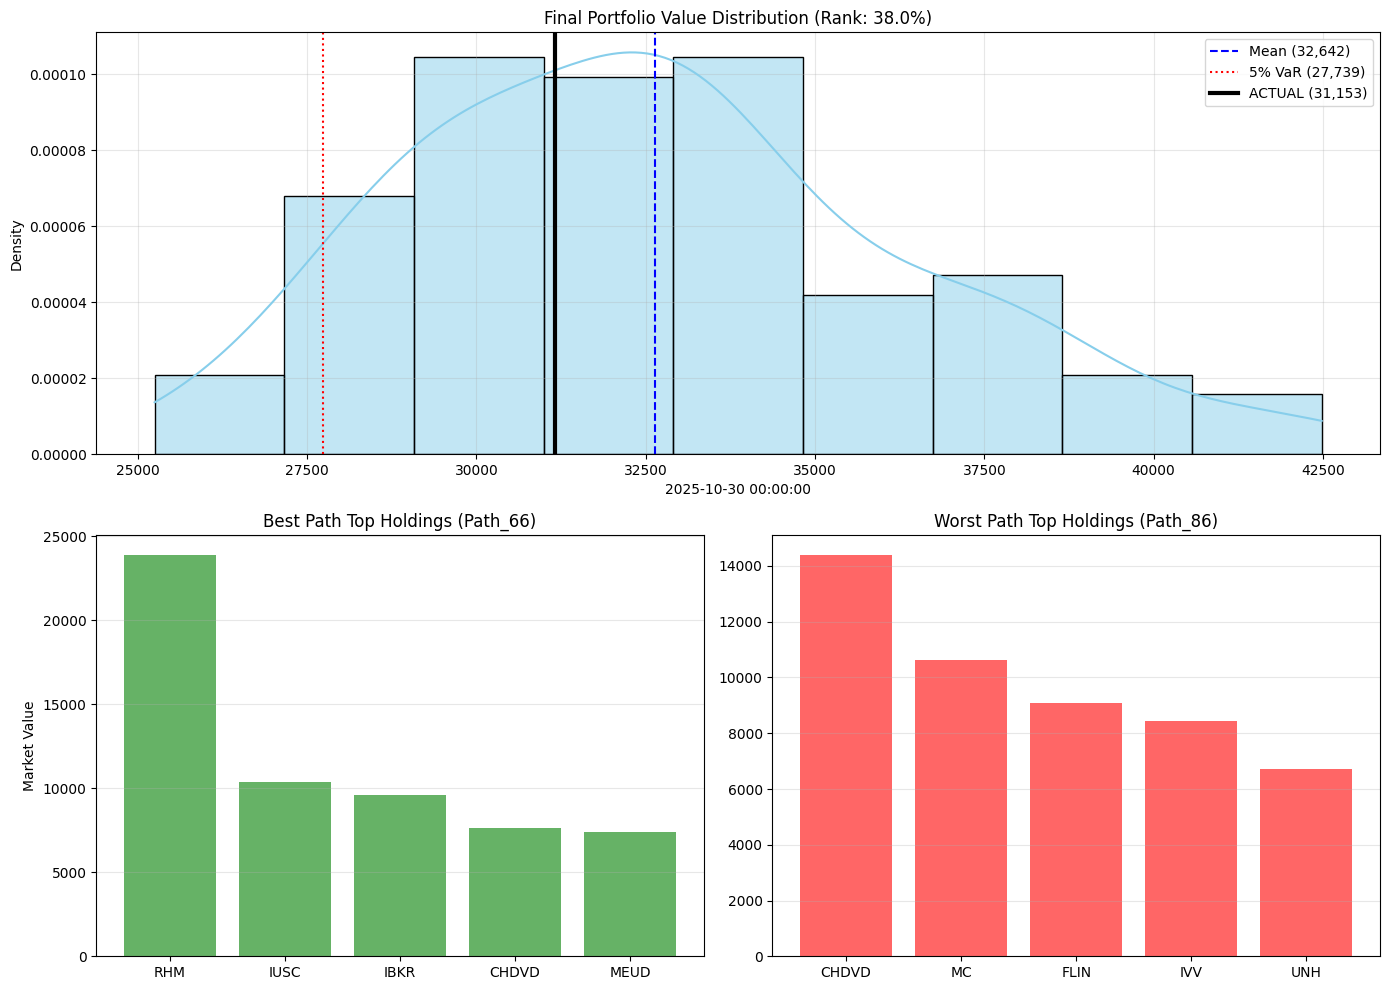

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CONFIGURATION & DATA EXTRACTION ---
# Ensure 'df_all_navs' and 'scenarios' and 'market_data' are in memory
if 'df_all_navs' not in globals() or 'scenarios' not in globals():
    raise ValueError("Missing simulation results. Run the simulation first.")

# Extract NAV series
actual_series = df_all_navs['ACTUAL_HISTORY']
sim_cols = [c for c in df_all_navs.columns if c.startswith('Path_')]
final_values = df_all_navs[sim_cols].iloc[-1]

# Identify Extremes
best_path_name = final_values.idxmax()
worst_path_name = final_values.idxmin()

best_idx = int(best_path_name.split('_')[1]) - 1
worst_idx = int(worst_path_name.split('_')[1]) - 1

# Print Header
print(f"{'='*40}")
print(f"MONTE CARLO RESULTS ANALYSIS")
print(f"{'='*40}")
print(f"Best Path:  {best_path_name:<10} | Final NAV: {final_values.max():,.2f}")
print(f"Worst Path: {worst_path_name:<10} | Final NAV: {final_values.min():,.2f}")
print(f"Actual NAV: {'ACTUAL':<10} | Final NAV: {actual_series.iloc[-1]:,.2f}")
print(f"{'-'*40}")

# --- 2. TRADE STRATEGY ANALYSIS (Net Cash Flow) ---

def get_trade_stats(scenario_pkg):
    events = scenario_pkg['events']
    trades = events[events['event_type'].isin(['TRADE_BUY', 'TRADE_SELL'])].copy()
    summary = trades.groupby('symbol').agg({
        'cash_change_native': 'sum',
        'quantity_change': 'count'
    }).rename(columns={'quantity_change': 'Count', 'cash_change_native': 'Net_Cash_Flow'})
    return summary.sort_values('Net_Cash_Flow')

print(f"\n>>> STRATEGY: BEST PATH ({best_path_name})")
print("Top 5 Aggressive Buys (Most Capital Spent):")
print(get_trade_stats(scenarios[best_idx]).head(5))

print(f"\n>>> STRATEGY: WORST PATH ({worst_path_name})")
print("Top 5 Aggressive Buys (Most Capital Spent):")
print(get_trade_stats(scenarios[worst_idx]).head(5))


# --- 3. HOLDINGS ANALYSIS (Final Portfolio) ---

def get_holdings(scenario_pkg):
    # Replay history to get final quantity
    h = {}
    # Initial State
    init = scenario_pkg['initial_state']
    for _, row in init[init['asset_category'] == 'Stock'].iterrows():
        h[row['symbol']] = row['quantity']
        
    # Events
    events = scenario_pkg['events'].sort_values('timestamp')
    for _, row in events.iterrows():
        sym = row['symbol']
        if not sym: continue
        if row['event_type'] in ['TRADE_BUY', 'TRADE_SELL']:
            h[sym] = h.get(sym, 0) + row['quantity_change']
        elif row['event_type'] == 'SPLIT':
            if sym in h: h[sym] = h[sym] * row['split_ratio']
            
    # Create DF
    df = pd.DataFrame.from_dict(h, orient='index', columns=['Qty'])
    df = df[df['Qty'] > 0.001] # Filter empty
    
    # Add Value
    vals = []
    for sym in df.index:
        price = market_data[sym]['Close'].iloc[-1] if sym in market_data else 0
        vals.append(df.loc[sym, 'Qty'] * price)
    df['Value'] = vals
    return df.sort_values('Value', ascending=False)

best_holdings = get_holdings(scenarios[best_idx])
worst_holdings = get_holdings(scenarios[worst_idx])

print(f"\n>>> HOLDINGS: BEST PATH ({best_path_name})")
print(best_holdings.head(5))

print(f"\n>>> HOLDINGS: WORST PATH ({worst_path_name})")
print(worst_holdings.head(5))


# --- 4. VISUALIZATION ---

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2)

# A. Distribution Plot (Top)
ax_dist = fig.add_subplot(gs[0, :])
sns.histplot(final_values, kde=True, color='skyblue', stat='density', ax=ax_dist)

mean_val = final_values.mean()
p05 = final_values.quantile(0.05)
actual = actual_series.iloc[-1]
percentile = (final_values < actual).mean() * 100

ax_dist.axvline(mean_val, color='blue', linestyle='--', label=f'Mean ({mean_val:,.0f})')
ax_dist.axvline(p05, color='red', linestyle=':', label=f'5% VaR ({p05:,.0f})')
ax_dist.axvline(actual, color='black', linewidth=3, label=f'ACTUAL ({actual:,.0f})')

ax_dist.set_title(f"Final Portfolio Value Distribution (Rank: {percentile:.1f}%)")
ax_dist.legend()
ax_dist.grid(alpha=0.3)

# B. Best Path Holdings (Bottom Left)
ax_best = fig.add_subplot(gs[1, 0])
top_best = best_holdings.head(5)
ax_best.bar(top_best.index, top_best['Value'], color='green', alpha=0.6)
ax_best.set_title(f"Best Path Top Holdings ({best_path_name})")
ax_best.set_ylabel("Market Value")
ax_best.grid(axis='y', alpha=0.3)

# C. Worst Path Holdings (Bottom Right)
ax_worst = fig.add_subplot(gs[1, 1])
top_worst = worst_holdings.head(5)
ax_worst.bar(top_worst.index, top_worst['Value'], color='red', alpha=0.6)
ax_worst.set_title(f"Worst Path Top Holdings ({worst_path_name})")
ax_worst.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# --- FORENSIC ANALYSIS: DGE vs CHDVD ---

import pandas as pd
import matplotlib.pyplot as plt

# 1. Check Market Data Integrity
print("--- MARKET DATA CHECK ---")
stocks_to_check = ['DGE', 'CHDVD', 'IVV', 'VTI', 'MC']

for sym in stocks_to_check:
    if sym in market_data:
        df = market_data[sym]
        start_price = df['Close'].iloc[0]
        end_price = df['Close'].iloc[-1]
        ret = (end_price / start_price) - 1
        divs = df['Dividends'].sum() if 'Dividends' in df.columns else 0
        
        print(f"{sym}: Start={start_price:.2f}, End={end_price:.2f}, Return={ret:.2%}, Total Divs={divs:.2f}")
    else:
        print(f"{sym}: Not found in market_data")

# 2. Deep Dive into Specific Trades
def inspect_trades(scenario, path_name, symbol):
    print(f"\n--- TRADES FOR {symbol} IN {path_name} ---")
    events = scenario['events']
    trades = events[(events['symbol'] == symbol) & (events['event_type'].isin(['TRADE_BUY', 'TRADE_SELL']))]
    
    if trades.empty:
        print("No trades found.")
        return

    for _, row in trades.iterrows():
        date = row['timestamp'].date()
        action = row['event_type']
        qty = row['quantity_change']
        price = abs(row['cash_change_native'] / qty)
        print(f"{date}: {action} {qty:.2f} @ {price:.2f}")

    # Check holdings at end
    # (Simplified holding calc)
    # ...

# Inspect Best Path (Path_9) for DGE
best_idx = 8 # Path_9 is index 8 (0-based)
inspect_trades(scenarios[best_idx], "Best Path", "DGE")

# Inspect Worst Path (Path_94) for CHDVD
worst_idx = 93 # Path_94 is index 93
inspect_trades(scenarios[worst_idx], "Worst Path", "CHDVD")

--- MARKET DATA CHECK ---
DGE: Start=31.83, End=17.55, Return=-44.85%, Total Divs=457.65
CHDVD: Start=136.80, End=169.82, Return=24.14%, Total Divs=46.26
IVV: Start=326.32, End=690.71, Return=111.67%, Total Divs=38.20
VTI: Start=164.98, End=337.71, Return=104.70%, Total Divs=18.78
MC: Start=419.15, End=618.80, Return=47.63%, Total Divs=56.60

--- TRADES FOR DGE IN Best Path ---
2025-02-07: TRADE_BUY 263.94 @ 22.22
2025-02-14: TRADE_BUY 162.21 @ 21.45
2025-02-24: TRADE_BUY 174.57 @ 21.99
2025-03-17: TRADE_SELL -87.94 @ 20.80

--- TRADES FOR CHDVD IN Worst Path ---
2025-02-10: TRADE_BUY 30.50 @ 169.96
2025-02-24: TRADE_BUY 25.01 @ 174.42
2025-07-02: TRADE_SELL -6.10 @ 165.34
2025-07-31: TRADE_BUY 7.94 @ 164.40
2025-10-29: TRADE_BUY 7.76 @ 169.82
